*Last edit by David Lao - 2018/08/16*



<br>
<br>


# Netflix Analytics - Movie Recommendation through Correlations / CF
<br>

I love Netflix!

This project aims to build a movie recommendation mechanism within Netflix. The dataset I used here come directly from Netflix. It consists of 4 text data files, each file contains over 20M rows, i.e. over 4K movies and 400K customers. All together **over 17K movies** and **500K+ customers**! 

<br>
One of the major challenges is to get all these data loaded into the Kernel for analysis, I have encountered many times of Kernel running out of memory and tried many different ways of how to do it more efficiently. Welcome any suggestions!!!

This kernel will be consistently be updated! Welcome any suggestions! Let's get started!

<br>
Feel free to fork and upvote if this notebook is helpful to you in some ways!


## Table of Content:

* Objective

* Data manipulation
    -  Data loading
    -  Data viewing
    -  Data cleaning
    -  Data slicing
    -  Data mapping
    
* Recommendation models
    -  Recommend with Collaborative Filtering (*Edit on 2017/11/07*)
    -  Recommend with Pearsons' R correlation

# Objective
<br>
Learn from data and recommend best TV shows to users, based on self & others behaviour
<br>

# Data manipulation

## Data loading

Each data file (there are 4 of them) contains below columns:

* Movie ID (as first line of each new movie record / file)
* Customer ID
* Rating (1 to 5)
* Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

Let's import the library we needed before we get started:

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

Next let's load first data file and get a feeling of how huge the dataset is:

In [2]:
# Skip date
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
df1.iloc[::5000000, :]

Dataset 1 shape: (24058263, 2)
-Dataset examples-


,Cust_Id,Rating
0,1:,NaN
5000000,2560324,4.0
10000000,2271935,2.0
15000000,1921803,2.0
20000000,1933327,3.0


Let's try to load the 3 remaining dataset as well:

In [3]:
df2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


Now we combine datasets:

In [4]:
# load less data for speed

df = df1
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
df.iloc[::5000000, :]

Full dataset shape: (100498277, 2)
-Dataset examples-


,Cust_Id,Rating
0,1:,NaN
5000000,2560324,4.0
10000000,2271935,2.0
15000000,1921803,2.0
20000000,1933327,3.0
25000000,1465002,3.0
30000000,961023,4.0
35000000,1372532,5.0
40000000,854274,5.0
45000000,116334,3.0


## Data viewing

Let's give a first look on how the data spread:

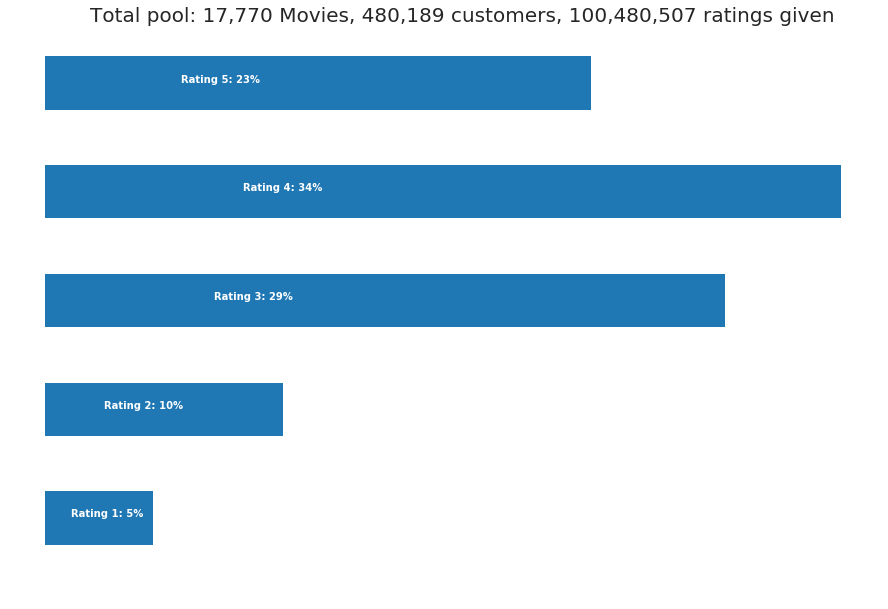

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [6]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [7]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [8]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 4040.0
Customer minimum times of review: 322.0


Now let's trim down our data, whats the difference in data size?

In [9]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (100480507, 3)
After Trim Shape: (56222526, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8902327   1546545     3.0      1770
17778828   905377     3.0      3408
26574940   578455     4.0      4951
35570704  1882719     4.0      6347
44484524  1852311     2.0      7882
53193841  1474296     4.0      9662
62065211  2235284     4.0     11283
71154226   846795     5.0     12891
80305377  1103969     3.0     14480
89157823  2535126     3.0     15844
98323041  2381067     3.0     17355


Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)


(96290, 3554)


## Data mapping

Now we load the movie mapping file:

In [11]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [12]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9800
MAE:  0.7890
------------
Fold 2
RMSE: 0.9857
MAE:  0.7903
------------
Fold 3
RMSE: 0.9835
MAE:  0.7982
------------
------------
Mean RMSE: 0.9831
Mean MAE : 0.7925
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9799516162265408,
                             0.9856832823527368,
                             0.9835303739548603],
                            'mae': [0.7890417958622864,
                             0.7903157159233447,
                             0.798179567346877]})

Below is what user 783514 liked in the past:

In [13]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Movie_Id
175                                         Reservoir Dogs
311                                                Ed Wood
329                                                  Dogma
331                                            Chasing Amy
788                                                 Clerks
798                                                   Jaws
907                                        Animal Crackers
985                                              The Mummy
1552                                           Black Adder
1905     Pirates of the Caribbean: The Curse of the Bla...
2000                           Four Weddings and a Funeral
2122                                  Being John Malkovich
2342                                         Super Size Me
2360                                   Singin' in the Rain
2430                            Alien: Collector's Edition
2443                              Like Water for Chocolate
2452         Lord of the Rings: The Fellowship 

Let's predict which movies user 785314 would love to watch:

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

/anaconda3/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?'

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

X2: X-Men United:

In [ ]:
recommend("X2: X-Men United", 0)

Hope it is a good read. I will keep updating this Kernel (more models etc). Welcome any suggestions!
